<a href="https://colab.research.google.com/github/rlallen-nps/IVF/blob/main/Voronoi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# make up data points
np.random.seed(1234)
points = np.random.rand(20, 2)
pointsV = np.random.rand(200, 2)


# compute Voronoi tesselation
vor = Voronoi(points)

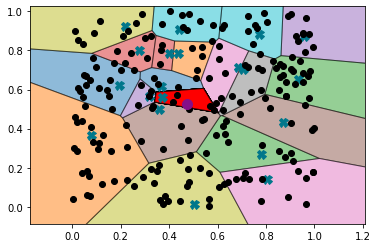

In [ ]:
# plot
regions, vertices = voronoi_finite_polygons_2d(vor)
# print("--")
# print(regions)
# print("--")
# print(vertices)

# colorize
for region in regions:
    polygon = vertices[region]
    # plt.fill(*zip(*polygon),"wo",edgecolor="black") # no color
    plt.fill(*zip(*polygon),alpha=0.5,edgecolor="black") # color

# Color just a single (10 is query cell)
for region in regions:
    polygon = vertices[regions[7]]
    plt.fill(*zip(*polygon),"ro", alpha=0.5, edgecolor="black") # no color    

# Color just a single (surounding are 1,3)
# for region in regions:
#     polygon = vertices[regions[5]]
#     plt.fill(*zip(*polygon),"ro", alpha=0.5, edgecolor="black") # no color 
# for region in regions:
#     polygon = vertices[regions[6]]
#     plt.fill(*zip(*polygon),"ro", alpha=0.5, edgecolor="black") # no color
# for region in regions:
#     polygon = vertices[regions[10]]
#     plt.fill(*zip(*polygon),"ro", alpha=0.5, edgecolor="black") # no color 
# for region in regions:
#     polygon = vertices[regions[14]]
#     plt.fill(*zip(*polygon),"ro", alpha=0.5, edgecolor="black") # no color
# for region in regions:
#     polygon = vertices[regions[17]]
#     plt.fill(*zip(*polygon),"ro", alpha=0.5, edgecolor="black") # no color 


plt.plot(points[:,0], points[:,1], 'rX',color='#00778b',markersize=9) # Centroids
plt.plot(pointsV[:,0], pointsV[:,1], 'ko') # Vectors
plt.plot(0.475,0.525,'o--',color='#850f89',markersize=10)
plt.xlim(vor.min_bound[0] - 0.25, vor.max_bound[0] + 0.25)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)
plt.rcParams["figure.figsize"] = (9,7)
plt.show()